# DelftaCalculator basics and $\Delta$-learning vs. direct learning 

In [1]:
import os
import glob
from openbabel.pybel import readfile, readstring
import numpy as np
from delfta.utils import TESTS_PATH

Next, we read a few example molecules from SDFs (structure data files) from the QMugs dataset. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [2]:
mol_files = glob.glob(os.path.join(TESTS_PATH, "mols_working", "CHEMBL*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value ($\omega$B97X-D/def2-SVP)) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [3]:
from delfta.calculator import DelftaCalculator

calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=True) 
# Verbose passing of arguments. We could've used "all" as well
predictions_delta = calc_delta.predict(mols, batch_size=32) # lower the batch size if you run into memory issues
calc_direct = DelftaCalculator(tasks="all", delta=False) 
# "all" means ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"]
predictions_direct = calc_direct.predict(mols)

2021/07/21 12:59:08 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 100/100 [00:41<00:00,  2.41it/s]
2021/07/21 12:59:49 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 100/100 [00:16<00:00,  6.03it/s]
2021/07/21 01:00:06 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 100/100 [00:16<00:00,  6.08it/s]
2021/07/21 01:00:22 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 100/100 [00:15<00:00,  6.33it/s]
2021/07/21 01:00:38 PM | DelFTa | INFO: Now running network for model multitask_direct...
100%|██████████| 100/100 [00:15<00:00,  6.35it/s]
2021/07/21 01:00:54 PM | DelFTa | INFO: Now running network for model single_energy_direct...
100%|██████████| 100/100 [00:15<00:00,  6.39it/s]
2021/07/21 01:01:10 PM | DelFTa | INFO: Now running network for model charges_direct...
100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Let's put the output in a dataframe to get an overview: 

In [4]:
import pandas as pd

df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,charges [e],E_form [Ha],E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D]
0,CHEMBL1257920_conf_01.sdf,"[-0.020935831677551267, -0.1015137895363617, 0...",-14.732017,-0.270840,0.010982,0.282313,3.415530
1,CHEMBL378974_conf_01.sdf,"[0.10677490548294068, -0.057110527646026615, -...",-11.562551,-0.280416,-0.011240,0.269290,4.915831
2,CHEMBL2435942_conf_01.sdf,"[-0.2724148017713928, 0.27677263297245025, -0....",-12.346744,-0.325216,0.010107,0.335699,5.612224
3,CHEMBL344765_conf_01.sdf,"[0.1365748663397789, -0.32971911779989244, 0.2...",-12.101528,-0.287392,0.020225,0.307263,3.088146
4,CHEMBL1927423_conf_00.sdf,"[-0.07547749290966033, 0.15673265835281372, -0...",-7.618086,-0.277305,0.028516,0.305644,4.663471
...,...,...,...,...,...,...,...
95,CHEMBL498248_conf_02.sdf,"[0.15891519900304796, -0.41293584782547, 0.195...",-9.072874,-0.304608,-0.055757,0.248253,2.621795
96,CHEMBL278994_conf_00.sdf,"[-0.04803074536790848, -0.06665857090370178, 0...",-13.483303,-0.286733,0.030126,0.316757,3.602752
97,CHEMBL2042151_conf_02.sdf,"[0.05112360345046997, -0.06111970180274963, -0...",-12.207154,-0.279879,0.021670,0.301641,6.835130
98,CHEMBL3617648_conf_01.sdf,"[0.009609298935508728, -0.01803570547193527, 0...",-10.371077,-0.313257,-0.007173,0.305967,3.259502


Get the DFT-calculated values from the QMugs SDFs and prepare everything for plotting:

In [5]:
predictions_delta["charges"] = np.concatenate(predictions_delta["charges"])
predictions_direct["charges"] = np.concatenate(predictions_direct["charges"])
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE", "DFT:MULLIKEN_CHARGES"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    elif dft_key == "DFT:MULLIKEN_CHARGES": 
        dft_values[dft_key] = [float(elem) for mol in mols for elem in mol.data[dft_key].split("|")]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



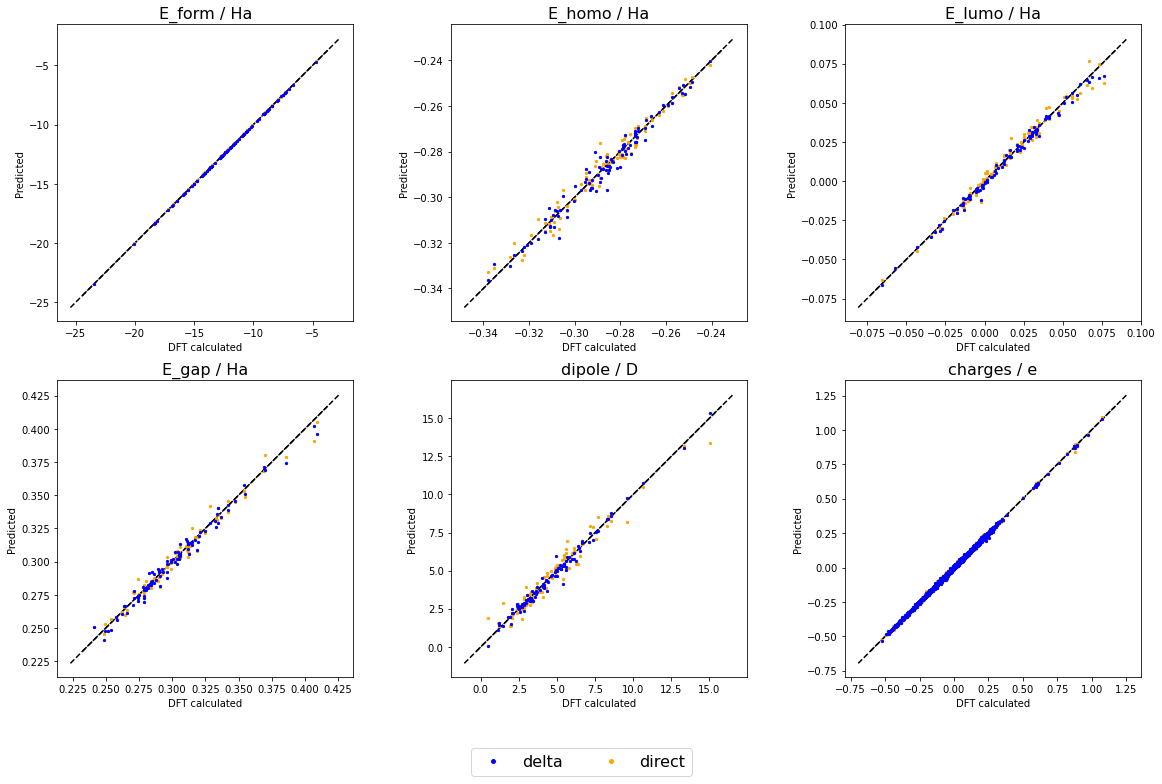

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def make_plot(ax, dft_vals, pred_vals, label, unit, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=5)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=3)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D", "e"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
for ax, dft_vals, pred_vals_delta, pred_vals_direct, label, unit in zip(axes, all_dft_vals, all_pred_vals_delta, all_pred_vals_direct, pred_keys, units): 
    make_plot(ax, dft_vals, pred_vals_direct, label, unit, "orange")
    make_plot(ax, dft_vals, pred_vals_delta, label, unit, "blue")
    ax.title.set_text(f"{label} / {unit}")
    ax.title.set_fontsize(16)

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

As you can see... ADD SOME INTERPRETATION FOR FINAL MODEL

You can also create molecules directly from SMILES. In that case, you need to keep `force3D=True` (the default), so that the Pybel generates a three-dimensional structure for the molecule using the MMFF94 force field. Alternatively, you can create three-dimensional coordinates in some other way and feed the molecule to the calculator afterwards.

In [9]:
mols = [readstring("smi", "O=C(C)Oc1ccccc1C(=O)O")] # aspirin
calc = DelftaCalculator(tasks="all", delta=True, force3d=True)
preds_delta = calc.predict(mols)
print(preds_delta)

2021/07/26 03:19:12 PM | DelFTa | INFO: Assigned MMFF94 coordinates and added hydrogens to molecules at position(s) [0]
2021/07/26 03:19:12 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 1/1 [00:00<00:00,  5.73it/s]
2021/07/26 03:19:13 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 1/1 [00:00<00:00, 12.09it/s]
2021/07/26 03:19:13 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 1/1 [00:00<00:00, 25.95it/s]
2021/07/26 03:19:13 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 1/1 [00:00<00:00, 25.12it/s]

{'charges': [array([-0.19550551,  0.1688277 , -0.08580162, -0.29297882,  0.20610422,
       -0.03956291,  0.01383139, -0.00107501, -0.00983949, -0.09921221,
        0.19771374, -0.22808755, -0.19687909,  0.06740789,  0.08235789,
        0.07070661,  0.03350517,  0.03565103,  0.02968433,  0.04361609,
        0.21268146])], 'E_form': array([-4.906168], dtype=float32), 'E_homo': array([-0.3431828], dtype=float32), 'E_lumo': array([-0.01242915], dtype=float32), 'E_gap': array([0.33059102], dtype=float32), 'dipole': array([3.6634927], dtype=float32)}
